In [1]:
import torch
import random
import numpy as np
from collections import deque
%run model.ipynb
from game import SnakeGameAI, Direction, Point
# from model import Linear_QNet, QTrainer
from helperp import plot 

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = .001
prev = 0
cnt = 0

<Figure size 640x480 with 0 Axes>

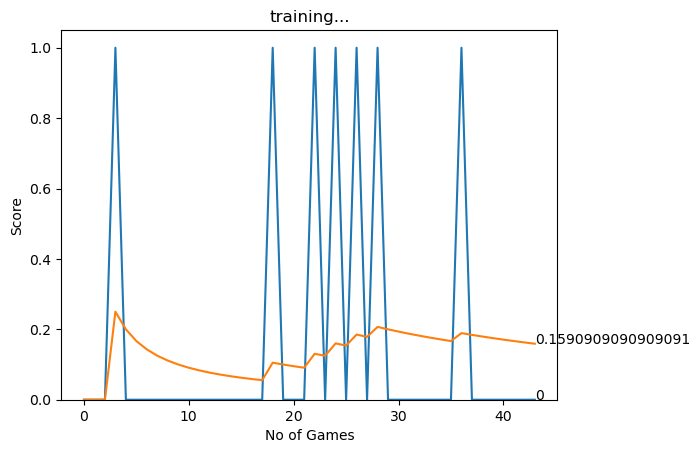

In [ ]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0.9 #RANDOMNESS
        self.gamma = 0 # DISCONT RATE
        self.memory = deque(maxlen=MAX_MEMORY) # full pop left
        self.model = Linear_QNet(11,256,3) #todo
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma) #todo
    
    def get_state(self, game):
        head = game.snake[0]
        point_l = Point(head.x-20, head.y)
        point_r = Point(head.x+20, head.y)
        point_u = Point(head.x, head.y-20)
        point_d = Point(head.x, head.y+20)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN
        
        state = [
            
            (dir_r and game.is_collision(point_r)) or
            (dir_l and game.is_collision(point_l)) or
            (dir_u and game.is_collision(point_u)) or
            (dir_d and game.is_collision(point_d)),
            
            (dir_u and game.is_collision(point_r)) or
            (dir_d and game.is_collision(point_l)) or
            (dir_r and game.is_collision(point_d)) or
            (dir_l and game.is_collision(point_u)) ,

            (dir_u and game.is_collision(point_l)) or
            (dir_d and game.is_collision(point_r)) or
            (dir_r and game.is_collision(point_u)) or
            (dir_l and game.is_collision(point_d)) ,
            
            #Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            game.food.x < game.head.x,
            game.food.x > game.head.x,
            game.food.y < game.head.y,
            game.food.y > game.head.y,
            
            ]
        return np.array(state, dtype = int)
    
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def train_long_memory(self):
        if len(self.memory)>BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)
        else:
            mini_sample = self.memory
    
        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
    
    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)
    
    def get_action(self, state):
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0,200) < self.epsilon:
            move = random.randint(0,2)
            f = 2
            if(f==2):
                prev = move
                cnt = 0
                f = -2
            if(prev==move):
                cnt+=1
                if cnt>8:
                    model = random.randint(0,2)
                    prev = model
            else:
                cnt=0
            final_move[move] = 1
                
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1
 
        return final_move
    

def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameAI()
    
    while True:
        state_old = agent.get_state(game)
        
        final_move = agent.get_action(state_old)
        
        reward, done, score = game.play_step(final_move)
        
        state_new = agent.get_state(game)
        
        agent.train_short_memory(state_old, final_move, reward, state_new, done)
        agent.remember(state_old, final_move, reward, state_new, done)
        
        if done: # if game over
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()
            
            if score>record:
                record = score
                agent.model.save()
            
            print('Game', agent.n_games, "Score", score, "Record", record)
            
            plot_scores.append(score)
            total_score += score
            mean_score = total_score/agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)
    
            
if __name__=="__main__":
    train()

In [35]:
import random
random.choice([0,1,2,1,2,1,0,2,1,2])

2